# Imports

In [ ]:
import sys
print(f"Python version is {sys.version}")

import torch
print(f"Torch version is {torch.__version__}")

import os
import time
import logging

from tqdm import tqdm

Python version is 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Torch version is 2.5.1+cu121


In [ ]:
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.resnet import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops import FeaturePyramidNetwork, MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator

# Helpers, utility

In [ ]:
# Ensure forward pass stability of the model
def test_model(input_type="real"):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.eval()

  # Change to random noise if prompted
  if input_type == "noise":
    sample_input = torch.randn(3, 800, 800)
    sample_input = sample_input.to(device)
  elif input_type == "real": # TODO: Implement
    pass

  with torch.no_grad():
      outputs = model([sample_input])

  print(f'Model output for input type: {input_type}')
  print(outputs)

test_model(input_type="noise")

Model output for input type: noise
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


## Inspect a sample

In [ ]:
def inspect_sample(dataset, index):
  # Load a sample from the dataset
  img, target = dataset[index]

  # Verify the image
  print(f"Image shape: {img.shape}")  # Should be [C, H, W]
  print(f"Image dtype: {img.dtype}")  # Should be torch.float32

  # Verify the target
  print(f"\nTarget keys: {target.keys()}")

  # Verify the bounding boxes
  print(f"\nBoxes: {target['boxes']}")
  print(f"Boxes shape: {target['boxes'].shape}")

  # Verify the labels
  print(f"\nLabels: {target['labels']}")
  print(f"Labels shape: {target['labels'].shape}")

  # Verify other target fields
  print(f"\nImage ID: {target['image_id']}")
  print(f"Area: {target['area']}")
  print(f"Iscrowd: {target['iscrowd']}")

inspect_sample(train_dataset, 0)

Image shape: torch.Size([3, 480, 640])
Image dtype: torch.float32

Target keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])

Boxes: tensor([[ 27.3300, 187.6900, 638.9200, 473.5300],
        [  8.9900,   4.3100, 328.2700, 232.9900],
        [ 74.1600, 229.2700, 390.4000, 474.3500],
        [205.5200,  13.5100, 640.0000, 388.6300],
        [188.2500,  40.3600, 263.8000,  86.8900],
        [116.1500,  38.9700, 174.2200,  85.6400],
        [170.2800,  73.6600, 254.3000, 144.1700],
        [181.1900,   2.4900, 275.9500,  73.5600]])
Boxes shape: torch.Size([8, 4])

Labels: tensor([46, 46, 51, 46, 50, 50, 50, 50])
Labels shape: torch.Size([8])

Image ID: tensor([9])
Area: tensor([120057.1406,  44434.7500,  49577.9453,  24292.7812,   2239.2925,
          1658.8914,   3609.3030,   2975.2759])
Iscrowd: tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# TODO: debug: for checking validity of bounding box bounds
# def validate_bboxes_subset(dataset, sample_size=2000):
#     """
#     Checks a random subset of the dataset to ensure bounding boxes are valid.
#     sample_size: how many samples to validate
#     """
#     num_samples = len(dataset)
#     sampled_indices = random.sample(range(num_samples), min(sample_size, num_samples))

#     invalid_samples = []
#     for idx in tqdm(sampled_indices, desc="Validating bounding boxes (subset)", unit="sample"):
#         img, target = dataset[idx]

#         # get image dimensions
#         _, img_height, img_width = img.shape
#         boxes = target['boxes'].cpu()

#         if boxes.size(0) == 0:
#             continue

#         widths = boxes[:, 2] - boxes[:, 0]
#         heights = boxes[:, 3] - boxes[:, 1]

#         invalid_mask = (
#             (widths <= 0) |
#             (heights <= 0) |
#             (boxes[:, 0] < 0) |
#             (boxes[:, 1] < 0) |
#             (boxes[:, 2] > img_width) |
#             (boxes[:, 3] > img_height)
#         )

#         if invalid_mask.any():
#             invalid_samples.append(idx)

#     if invalid_samples:
#         print("Found invalid bounding boxes in these samples:", invalid_samples)
#     else:
#         print(f"\nNo invalid bounding boxes found in this random subset of {len(sampled_indices)} samples.")

#     return invalid_samples


# invalid_samples = validate_bboxes_subset(train_dataset, sample_size=2000)


## Visualize the Image and Bounding Boxes

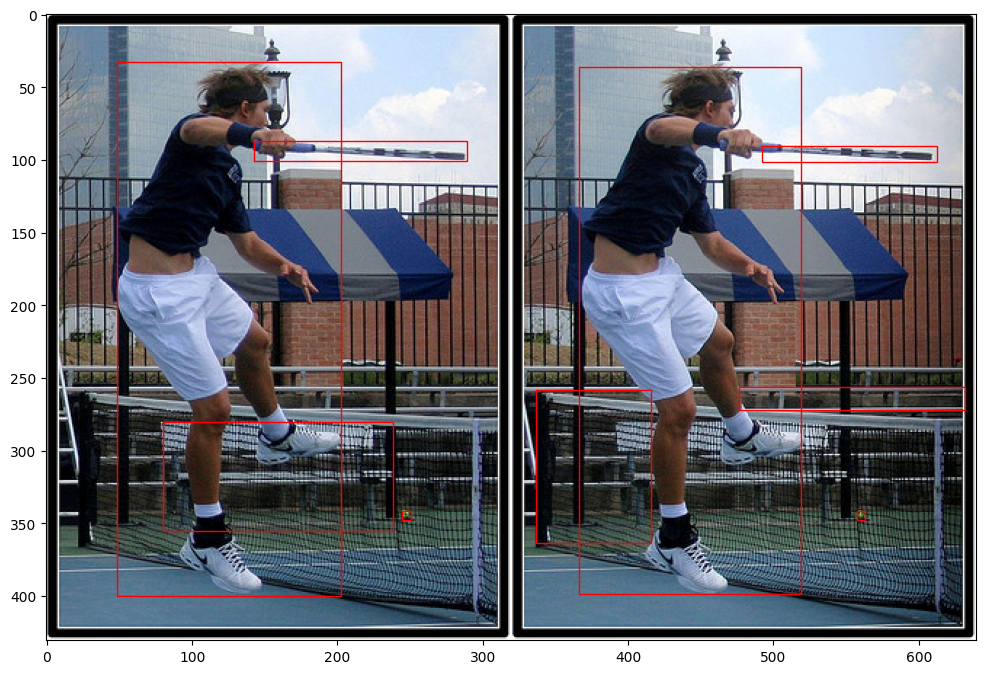

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_boxes(img, target):
    # Convert the image tensor to a NumPy array and transpose to [H, W, C]
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)

    boxes = target['boxes']
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

    plt.show()

# Fetch a random sample from the dataset
random_index = random.randint(0, len(train_dataset))
img, target = train_dataset[random_index]

# Visualize the sample
visualize_image_with_boxes(img, target)

## Test-Fetch Batches

In [ ]:
# Fetch multiple batches to ensure consistency
for _ in range(5):
    images, targets = next(iter(train_loader))
    print(f"Number of images: {len(images)}")

Number of images: 2
Number of images: 2
Number of images: 2
Number of images: 2
Number of images: 2


In [ ]:
# Fetch a batch
images, targets = next(iter(train_loader))

# Verify the batch
print(f"Number of images: {len(images)}")
print(f"Image 0 shape: {images[0].shape}")
print(f"Image 1 shape: {images[1].shape}")
print(f"Target 0 keys: {targets[0].keys()}")
print(f"Target 1 keys: {targets[1].keys()}")

Number of images: 2
Image 0 shape: torch.Size([3, 408, 640])
Image 1 shape: torch.Size([3, 333, 500])
Target 0 keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])
Target 1 keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])


# main.py

## Run configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To be able to import .py scripts stored under src/
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/src')
import os
import torch
from datetime import datetime


# Run parameters
model_type = "custom_FADE" # TODO: custom_FADE or "baseline"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################################################################
# PATHS
##############################################################################
base_path = "/content/drive/MyDrive"
project_dir = os.path.join(base_path, "Colab Notebooks", "cmpe593", "term-project")

## Dataset paths
dataset_split = "train2017" # TODO: pick from ("train2017", "val2017")
coco_base_dir = f'{base_path}/coco'
images_dir = os.path.join(coco_base_dir, 'images', dataset_split)
annotations_path = os.path.join(coco_base_dir,
                                'annotations',
                                f'instances_{dataset_split}.json')

## Artifact paths (checkpoints, plots, metrics)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(project_dir, 'results', timestamp)
checkpoint_dir = os.path.join(results_dir, 'checkpoints')
plot_dir = os.path.join(results_dir, 'plots')
metrics_dir = os.path.join(results_dir, 'metrics')


# Ensure artifact paths exist
for dir in [results_dir, checkpoint_dir, plot_dir, metrics_dir]:
  if not os.path.exists(dir):
    os.makedirs(dir)
    print(f'Directory created at {dir}')
  else:
    print(f'Directory {dir} already exists.')
##############################################################################

Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623
Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints
Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/plots
Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/metrics


## Load data and model

In [ ]:
from dataops.data_loader import get_data_loader
from torch.utils.data import Subset


def get_num_classes(dataloader):
    """
    Retrieve the number of classes from the dataset used by the dataloader.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object.

    Returns:
        int: Number of classes.
    """
    # Access the original dataset
    dataset = dataloader.dataset.dataset if isinstance(dataloader.dataset, Subset) else dataloader.dataset

    # Retrieve category IDs
    category_ids = dataset.cat_ids
    print(f"Number of categories: {len(category_ids)}")
    return len(category_ids), category_ids


# Get data loader and number of classes inside the dataset
dataloader = get_data_loader(images_dir, annotations_path, train=True, subset=True, subset_size=10000)
num_classes, category_ids = get_num_classes(dataloader)

Drive already mounted at /content/drive.

Image file directory: /content/drive/MyDrive/coco/images/train2017
Does image directory exist? True

Annotation file path: /content/drive/MyDrive/coco/annotations/instances_train2017.json
Does annotation file exist? True
Drive already mounted at /content/drive.

Generating image IDs...


Processing images: 100%|██████████| 70875/70875 [00:00<00:00, 1146026.67file/s]


Total of 70875 image IDs were generated.
loading annotations into memory...
Done (t=47.00s)
creating index...
index created!

Dataset size is 70875

Creating subset of dataset with size 10000...
Creating dataloader object...
Number of categories: 80


In [ ]:
from modelops import model_loader

model = model_loader.load_model(
    model_type=model_type,
    device=device,
    eval_mode=False
)

Creating custom FADE model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Custom FADE model loaded.
Loaded custom_FADE model for training on cuda.


## Modeling

### Set parameters and optimizer

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# Set hyperparameters
num_classes = len(category_ids) + 1  # +1 for background
quick_experiment = False
hyperparam_key = 'quick_experiment' if quick_experiment else 'longer_experiment'

hyperparameters = {
    'quick_experiment': {
        'lr_scheduler': None,
        'lr': 0.01,
        'momentum': 0.9,
        'weight_decay': 0.0005,
        'num_epochs': 3,
    },

    'longer_experiment': {
        'lr_scheduler': 'warmup',
        'lr': 0.01,
        'momentum': 0.9,
        'weight_decay': 0.0005,
        'num_epochs': 10,
    },
}

# Extract hyperparameters
active_hparams = hyperparameters[hyperparam_key]
lr = active_hparams['lr']
momentum = active_hparams['momentum']
weight_decay = active_hparams['weight_decay']
num_epochs = active_hparams['num_epochs']

# Initialize model parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer
optimizer = optim.SGD(
    params,
    lr=lr,  # Applies to all parameters
    momentum=momentum,
    weight_decay=weight_decay
)

def warmup_schedule(epoch):
    warmup_epochs = 3
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs  # Start from a small value and scale up
    return 1.0  # Maintain full learning rate after warm-up

# Apply the scheduler
lr_scheduler = LambdaLR(optimizer, lr_lambda=warmup_schedule)

# Print learning rate for debugging
print("Learning Rate Scheduler Test:")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}: LR = {optimizer.param_groups[0]['lr']:.6f}")
    lr_scheduler.step()

Learning Rate Scheduler Test:
Epoch 1: LR = 0.003333
Epoch 2: LR = 0.006667
Epoch 3: LR = 0.010000
Epoch 4: LR = 0.010000
Epoch 5: LR = 0.010000
Epoch 6: LR = 0.010000
Epoch 7: LR = 0.010000
Epoch 8: LR = 0.010000
Epoch 9: LR = 0.010000
Epoch 10: LR = 0.010000


### Save params for debugging purposes

In [ ]:
import json

# Path to save the hyperparameters file
hyperparams_path = os.path.join(results_dir, "hyperparameters.json")
active_hparams['model_type'] = f'{model_type}-{model.__class__.__name__}'

# Save hyperparameters
with open(hyperparams_path, "w") as f:
    json.dump(active_hparams, f, indent=4)

print(f"Hyperparameters saved to {hyperparams_path}")

Hyperparameters saved to /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/hyperparameters.json


In [ ]:
import time
import shutil
import datetime
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs,
    drive_checkpoint_dir,
    lr_scheduler=None,
    val_loader=None,
):
  epoch_losses = []
  error_batches = []  # To store details of failing batches for debug
  ap_history = []     # To store AP metrics after each epoch

  for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0.0
      start_time = time.time()
      batch_count = 0

      print(f"Epoch {epoch + 1}/{num_epochs}")
      print('-' * 20)

      # Training loop
      for images, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch"):
          batch_count += 1

          # Move images and targets to the device
          images = [img.to(device) for img in images]
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          try:
              # Forward pass
              loss_dict = model(images, targets)
          except AssertionError as e:
              print(f"\n[ERROR] Bounding box error in batch {batch_count}!")
              print("Inspecting bounding boxes for each sample in this batch:")
              batch_error_info = {"epoch": epoch+1, "batch_idx": batch_count, "boxes": []}

              for i, tgt in enumerate(targets):
                  print(f"Sample index in batch: {i}, boxes:\n{tgt['boxes']}")
                  # Collect boxes info for later debug
                  batch_error_info["boxes"].append(tgt['boxes'].cpu().tolist())

              # Store the error info
              error_batches.append(batch_error_info)
              # Skip this batch rather than crashing
              continue

          # Compute total loss
          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          epoch_loss += loss_value

          # Backward pass and optimization
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          # Display intermediate losses
          if batch_count % 100 == 0:
              print(f"Batch {batch_count}, Loss: {loss_value:.4f}")

      current_lr = optimizer.param_groups[0]['lr']

      # Step the learning rate scheduler
      if lr_scheduler:
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

      epoch_duration = time.time() - start_time
      epoch_duration_str = str(datetime.timedelta(seconds=int(epoch_duration)))

      average_epoch_loss = epoch_loss / len(train_loader)
      epoch_losses.append(average_epoch_loss)

      # Display epoch summary
      print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {epoch_duration_str}")
      print(f"Average Loss: {average_epoch_loss:.4f}")
      print(f"Current Learning Rate: {current_lr:.6f}")

      # Save the checkpoint directly to Google Drive
      drive_checkpoint_path = os.path.join(drive_checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
      torch.save(model.state_dict(), drive_checkpoint_path)
      print(f"Checkpoint saved to Google Drive at {drive_checkpoint_path}")

  # =========================
  # Training loop completes
  # =========================
  print("Training loop finished.")

  # Save the model state dictionary directly to the target path
  drive_final_checkpoint_path = os.path.join(drive_checkpoint_dir, 'model_final.pth')
  torch.save(model.state_dict(), drive_final_checkpoint_path)
  print(f"Final model saved to Google Drive at {drive_final_checkpoint_path}")

  # Save then display the training loss plot
  import matplotlib.pyplot as plt

  plot_filename_drive = os.path.join(drive_checkpoint_dir, 'training_loss_plot.png')
  plt.figure()
  plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.title('Training Loss Over Epochs')
  plt.grid(True)
  plt.savefig(plot_filename_drive)
  print(f"Training loss plot saved to Google Drive at {plot_filename_drive}")
  plt.show()

  if error_batches:
      print("\nSome batches triggered bounding box assertions. Their info:")
      for info in error_batches:
          print(f"Epoch {info['epoch']}, Batch {info['batch_idx']}, Boxes: {info['boxes']}")
  else:
      print("No bounding box errors encountered!")

Epoch 1/10
--------------------


Epoch 1:   2%|▏         | 100/5000 [00:41<31:34,  2.59batch/s]

Batch 100, Loss: 1.1283


Epoch 1:   4%|▍         | 200/5000 [01:19<37:50,  2.11batch/s]

Batch 200, Loss: 1.4984


Epoch 1:   6%|▌         | 301/5000 [01:57<28:07,  2.78batch/s]

Batch 300, Loss: 1.0349


Epoch 1:   8%|▊         | 401/5000 [02:36<21:47,  3.52batch/s]

Batch 400, Loss: 1.3086


Epoch 1:  10%|█         | 501/5000 [03:14<20:00,  3.75batch/s]

Batch 500, Loss: 1.2590


Epoch 1:  12%|█▏        | 601/5000 [03:51<22:29,  3.26batch/s]

Batch 600, Loss: 1.0431


Epoch 1:  14%|█▍        | 701/5000 [04:28<26:06,  2.74batch/s]

Batch 700, Loss: 1.2323


Epoch 1:  16%|█▌        | 801/5000 [05:07<31:09,  2.25batch/s]

Batch 800, Loss: 0.9340


Epoch 1:  18%|█▊        | 901/5000 [05:44<24:40,  2.77batch/s]

Batch 900, Loss: 0.8289


Epoch 1:  20%|██        | 1001/5000 [06:22<22:44,  2.93batch/s]

Batch 1000, Loss: 0.6952


Epoch 1:  22%|██▏       | 1101/5000 [06:59<23:30,  2.76batch/s]

Batch 1100, Loss: 1.1766


Epoch 1:  24%|██▍       | 1200/5000 [07:37<18:57,  3.34batch/s]

Batch 1200, Loss: 1.1193


Epoch 1:  26%|██▌       | 1301/5000 [08:17<19:08,  3.22batch/s]

Batch 1300, Loss: 1.4231


Epoch 1:  28%|██▊       | 1401/5000 [08:55<16:53,  3.55batch/s]

Batch 1400, Loss: 0.8971


Epoch 1:  30%|███       | 1501/5000 [09:33<17:29,  3.33batch/s]

Batch 1500, Loss: 0.9065


Epoch 1:  32%|███▏      | 1601/5000 [10:12<18:19,  3.09batch/s]

Batch 1600, Loss: 0.8144


Epoch 1:  34%|███▍      | 1701/5000 [10:50<18:49,  2.92batch/s]

Batch 1700, Loss: 1.4453


Epoch 1:  36%|███▌      | 1801/5000 [11:28<18:07,  2.94batch/s]

Batch 1800, Loss: 1.2175


Epoch 1:  38%|███▊      | 1901/5000 [12:06<16:01,  3.22batch/s]

Batch 1900, Loss: 0.5700


Epoch 1:  40%|████      | 2001/5000 [12:45<13:29,  3.70batch/s]

Batch 2000, Loss: 1.3365


Epoch 1:  42%|████▏     | 2101/5000 [13:22<11:53,  4.06batch/s]

Batch 2100, Loss: 1.1915


Epoch 1:  44%|████▍     | 2201/5000 [14:00<12:52,  3.62batch/s]

Batch 2200, Loss: 1.2559


Epoch 1:  46%|████▌     | 2301/5000 [14:38<14:34,  3.09batch/s]

Batch 2300, Loss: 0.8479


Epoch 1:  48%|████▊     | 2401/5000 [15:15<11:50,  3.66batch/s]

Batch 2400, Loss: 0.9456


Epoch 1:  50%|█████     | 2501/5000 [15:54<13:36,  3.06batch/s]

Batch 2500, Loss: 1.0854


Epoch 1:  52%|█████▏    | 2600/5000 [16:31<12:13,  3.27batch/s]

Batch 2600, Loss: 3.0247


Epoch 1:  54%|█████▍    | 2700/5000 [17:09<13:11,  2.91batch/s]

Batch 2700, Loss: 0.9154


Epoch 1:  56%|█████▌    | 2800/5000 [17:47<10:18,  3.56batch/s]

Batch 2800, Loss: 1.0066


Epoch 1:  58%|█████▊    | 2900/5000 [18:25<10:13,  3.42batch/s]

Batch 2900, Loss: 0.6128


Epoch 1:  60%|██████    | 3001/5000 [19:03<12:18,  2.71batch/s]

Batch 3000, Loss: 1.0377


Epoch 1:  62%|██████▏   | 3101/5000 [19:41<08:32,  3.70batch/s]

Batch 3100, Loss: 0.7031


Epoch 1:  64%|██████▍   | 3201/5000 [20:20<07:46,  3.85batch/s]

Batch 3200, Loss: 0.9776


Epoch 1:  66%|██████▌   | 3301/5000 [20:57<07:30,  3.77batch/s]

Batch 3300, Loss: 0.6523


Epoch 1:  68%|██████▊   | 3401/5000 [21:36<07:15,  3.67batch/s]

Batch 3400, Loss: 1.2606


Epoch 1:  70%|███████   | 3501/5000 [22:13<06:01,  4.14batch/s]

Batch 3500, Loss: 1.8612


Epoch 1:  72%|███████▏  | 3601/5000 [22:52<05:52,  3.97batch/s]

Batch 3600, Loss: 0.7438


Epoch 1:  74%|███████▍  | 3701/5000 [23:30<05:47,  3.74batch/s]

Batch 3700, Loss: 1.3103


Epoch 1:  76%|███████▌  | 3801/5000 [24:08<04:45,  4.20batch/s]

Batch 3800, Loss: 0.2736


Epoch 1:  78%|███████▊  | 3901/5000 [24:45<04:48,  3.80batch/s]

Batch 3900, Loss: 1.5058


Epoch 1:  80%|████████  | 4000/5000 [25:23<05:35,  2.98batch/s]

Batch 4000, Loss: 1.7047


Epoch 1:  82%|████████▏ | 4101/5000 [26:02<05:18,  2.82batch/s]

Batch 4100, Loss: 0.4962


Epoch 1:  84%|████████▍ | 4201/5000 [26:39<04:29,  2.96batch/s]

Batch 4200, Loss: 0.4225


Epoch 1:  86%|████████▌ | 4301/5000 [27:17<03:24,  3.41batch/s]

Batch 4300, Loss: 1.9004


Epoch 1:  88%|████████▊ | 4401/5000 [27:55<02:56,  3.40batch/s]

Batch 4400, Loss: 1.2458


Epoch 1:  90%|█████████ | 4500/5000 [28:32<03:21,  2.49batch/s]

Batch 4500, Loss: 1.2626


Epoch 1:  92%|█████████▏| 4601/5000 [29:10<02:05,  3.19batch/s]

Batch 4600, Loss: 1.0060


Epoch 1:  94%|█████████▍| 4700/5000 [29:47<01:38,  3.04batch/s]

Batch 4700, Loss: 0.8941


Epoch 1:  96%|█████████▌| 4800/5000 [30:26<00:53,  3.73batch/s]

Batch 4800, Loss: 1.7654


Epoch 1:  98%|█████████▊| 4900/5000 [31:03<00:24,  4.16batch/s]

Batch 4900, Loss: 1.1006


Epoch 1: 100%|██████████| 5000/5000 [31:40<00:00,  2.63batch/s]

Batch 5000, Loss: 1.1837
Epoch [1/10] completed in 0:31:40
Average Loss: 1.2814
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_1.pth
Epoch 2/10
--------------------


Epoch 2:   2%|▏         | 101/5000 [00:14<10:57,  7.45batch/s]

Batch 100, Loss: 1.7503


Epoch 2:   4%|▍         | 201/5000 [00:27<11:01,  7.26batch/s]

Batch 200, Loss: 0.7293


Epoch 2:   6%|▌         | 301/5000 [00:41<10:01,  7.81batch/s]

Batch 300, Loss: 0.2789


Epoch 2:   8%|▊         | 401/5000 [00:54<09:57,  7.70batch/s]

Batch 400, Loss: 1.8980


Epoch 2:  10%|█         | 501/5000 [01:08<11:07,  6.74batch/s]

Batch 500, Loss: 0.8863


Epoch 2:  12%|█▏        | 601/5000 [01:21<10:39,  6.88batch/s]

Batch 600, Loss: 1.4328


Epoch 2:  14%|█▍        | 701/5000 [01:35<09:23,  7.63batch/s]

Batch 700, Loss: 0.7680


Epoch 2:  16%|█▌        | 801/5000 [01:49<09:44,  7.18batch/s]

Batch 800, Loss: 1.9640


Epoch 2:  18%|█▊        | 901/5000 [02:02<09:24,  7.26batch/s]

Batch 900, Loss: 1.7289


Epoch 2:  20%|██        | 1001/5000 [02:16<08:27,  7.89batch/s]

Batch 1000, Loss: 0.8638


Epoch 2:  22%|██▏       | 1101/5000 [02:29<08:32,  7.61batch/s]

Batch 1100, Loss: 0.2921


Epoch 2:  24%|██▍       | 1201/5000 [02:43<09:09,  6.92batch/s]

Batch 1200, Loss: 1.1124


Epoch 2:  26%|██▌       | 1301/5000 [02:56<08:05,  7.62batch/s]

Batch 1300, Loss: 1.5002


Epoch 2:  28%|██▊       | 1401/5000 [03:09<07:52,  7.61batch/s]

Batch 1400, Loss: 0.9583


Epoch 2:  30%|███       | 1501/5000 [03:22<07:18,  7.97batch/s]

Batch 1500, Loss: 1.6752


Epoch 2:  32%|███▏      | 1601/5000 [03:36<06:57,  8.14batch/s]

Batch 1600, Loss: 2.4388


Epoch 2:  34%|███▍      | 1701/5000 [03:50<06:58,  7.89batch/s]

Batch 1700, Loss: 1.5303


Epoch 2:  36%|███▌      | 1801/5000 [04:03<06:37,  8.05batch/s]

Batch 1800, Loss: 1.1512


Epoch 2:  38%|███▊      | 1901/5000 [04:17<06:29,  7.95batch/s]

Batch 1900, Loss: 0.4003


Epoch 2:  40%|████      | 2001/5000 [04:30<06:30,  7.67batch/s]

Batch 2000, Loss: 0.7457


Epoch 2:  42%|████▏     | 2101/5000 [04:43<06:05,  7.94batch/s]

Batch 2100, Loss: 1.0123


Epoch 2:  44%|████▍     | 2201/5000 [04:57<06:30,  7.16batch/s]

Batch 2200, Loss: 0.9731


Epoch 2:  46%|████▌     | 2301/5000 [05:10<06:16,  7.16batch/s]

Batch 2300, Loss: 1.3558


Epoch 2:  48%|████▊     | 2401/5000 [05:24<05:38,  7.69batch/s]

Batch 2400, Loss: 1.5758


Epoch 2:  50%|█████     | 2501/5000 [05:37<05:39,  7.36batch/s]

Batch 2500, Loss: 1.1692


Epoch 2:  52%|█████▏    | 2601/5000 [05:50<05:11,  7.70batch/s]

Batch 2600, Loss: 0.8390


Epoch 2:  54%|█████▍    | 2701/5000 [06:04<05:21,  7.15batch/s]

Batch 2700, Loss: 1.4285


Epoch 2:  56%|█████▌    | 2801/5000 [06:18<05:12,  7.04batch/s]

Batch 2800, Loss: 1.0814


Epoch 2:  58%|█████▊    | 2901/5000 [06:31<04:25,  7.89batch/s]

Batch 2900, Loss: 0.7100


Epoch 2:  60%|██████    | 3001/5000 [06:44<04:36,  7.23batch/s]

Batch 3000, Loss: 0.3909


Epoch 2:  62%|██████▏   | 3101/5000 [06:58<04:09,  7.61batch/s]

Batch 3100, Loss: 1.2531


Epoch 2:  64%|██████▍   | 3201/5000 [07:11<03:55,  7.63batch/s]

Batch 3200, Loss: 0.3275


Epoch 2:  66%|██████▌   | 3301/5000 [07:25<03:55,  7.22batch/s]

Batch 3300, Loss: 0.8950


Epoch 2:  68%|██████▊   | 3401/5000 [07:38<03:34,  7.47batch/s]

Batch 3400, Loss: 0.8786


Epoch 2:  70%|███████   | 3501/5000 [07:52<03:23,  7.38batch/s]

Batch 3500, Loss: 0.3297


Epoch 2:  72%|███████▏  | 3601/5000 [08:05<02:56,  7.92batch/s]

Batch 3600, Loss: 1.4147


Epoch 2:  74%|███████▍  | 3701/5000 [08:19<02:54,  7.46batch/s]

Batch 3700, Loss: 1.0496


Epoch 2:  76%|███████▌  | 3801/5000 [08:32<02:54,  6.86batch/s]

Batch 3800, Loss: 1.0222


Epoch 2:  78%|███████▊  | 3901/5000 [08:46<02:34,  7.11batch/s]

Batch 3900, Loss: 0.6143


Epoch 2:  80%|████████  | 4001/5000 [08:59<02:07,  7.86batch/s]

Batch 4000, Loss: 1.4608


Epoch 2:  82%|████████▏ | 4101/5000 [09:13<02:04,  7.21batch/s]

Batch 4100, Loss: 1.1888


Epoch 2:  84%|████████▍ | 4201/5000 [09:26<01:37,  8.17batch/s]

Batch 4200, Loss: 1.5107


Epoch 2:  86%|████████▌ | 4301/5000 [09:39<01:28,  7.94batch/s]

Batch 4300, Loss: 1.3779


Epoch 2:  88%|████████▊ | 4401/5000 [09:53<01:16,  7.83batch/s]

Batch 4400, Loss: 1.1999


Epoch 2:  90%|█████████ | 4501/5000 [10:06<01:07,  7.38batch/s]

Batch 4500, Loss: 1.2819


Epoch 2:  92%|█████████▏| 4601/5000 [10:20<00:54,  7.37batch/s]

Batch 4600, Loss: 1.0127


Epoch 2:  94%|█████████▍| 4701/5000 [10:33<00:43,  6.91batch/s]

Batch 4700, Loss: 0.8208


Epoch 2:  96%|█████████▌| 4801/5000 [10:47<00:25,  7.83batch/s]

Batch 4800, Loss: 1.0827


Epoch 2:  98%|█████████▊| 4901/5000 [11:00<00:14,  6.79batch/s]

Batch 4900, Loss: 1.3892


Epoch 2: 100%|██████████| 5000/5000 [11:14<00:00,  7.42batch/s]

Batch 5000, Loss: 1.2127
Epoch [2/10] completed in 0:11:14
Average Loss: 1.2308
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_2.pth
Epoch 3/10
--------------------


Epoch 3:   2%|▏         | 101/5000 [00:13<10:49,  7.54batch/s]

Batch 100, Loss: 1.7616


Epoch 3:   4%|▍         | 201/5000 [00:27<10:38,  7.52batch/s]

Batch 200, Loss: 1.8411


Epoch 3:   6%|▌         | 301/5000 [00:40<11:12,  6.99batch/s]

Batch 300, Loss: 1.0894


Epoch 3:   8%|▊         | 401/5000 [00:54<10:57,  6.99batch/s]

Batch 400, Loss: 1.8145


Epoch 3:  10%|█         | 501/5000 [01:08<10:17,  7.28batch/s]

Batch 500, Loss: 0.7247


Epoch 3:  12%|█▏        | 601/5000 [01:21<09:38,  7.61batch/s]

Batch 600, Loss: 1.3677


Epoch 3:  14%|█▍        | 701/5000 [01:35<09:37,  7.45batch/s]

Batch 700, Loss: 1.4196


Epoch 3:  16%|█▌        | 801/5000 [01:48<09:57,  7.02batch/s]

Batch 800, Loss: 0.6818


Epoch 3:  18%|█▊        | 901/5000 [02:01<09:50,  6.95batch/s]

Batch 900, Loss: 1.0074


Epoch 3:  20%|██        | 1001/5000 [02:15<08:53,  7.50batch/s]

Batch 1000, Loss: 1.4988


Epoch 3:  22%|██▏       | 1101/5000 [02:28<08:28,  7.67batch/s]

Batch 1100, Loss: 1.1079


Epoch 3:  24%|██▍       | 1201/5000 [02:42<08:52,  7.14batch/s]

Batch 1200, Loss: 0.4302


Epoch 3:  26%|██▌       | 1300/5000 [02:55<07:53,  7.82batch/s]

Batch 1300, Loss: 1.1944


Epoch 3:  28%|██▊       | 1401/5000 [03:09<07:37,  7.86batch/s]

Batch 1400, Loss: 1.6876


Epoch 3:  30%|███       | 1501/5000 [03:22<07:43,  7.54batch/s]

Batch 1500, Loss: 2.1028


Epoch 3:  32%|███▏      | 1601/5000 [03:36<07:22,  7.68batch/s]

Batch 1600, Loss: 1.2401


Epoch 3:  34%|███▍      | 1701/5000 [03:49<07:38,  7.20batch/s]

Batch 1700, Loss: 1.3461


Epoch 3:  36%|███▌      | 1801/5000 [04:03<07:05,  7.51batch/s]

Batch 1800, Loss: 1.1902


Epoch 3:  38%|███▊      | 1901/5000 [04:16<07:15,  7.12batch/s]

Batch 1900, Loss: 1.1977


Epoch 3:  40%|████      | 2001/5000 [04:29<06:39,  7.51batch/s]

Batch 2000, Loss: 0.8032


Epoch 3:  42%|████▏     | 2101/5000 [04:43<06:44,  7.17batch/s]

Batch 2100, Loss: 1.7907


Epoch 3:  44%|████▍     | 2201/5000 [04:56<05:59,  7.78batch/s]

Batch 2200, Loss: 1.4658


Epoch 3:  46%|████▌     | 2301/5000 [05:09<05:56,  7.57batch/s]

Batch 2300, Loss: 0.6887


Epoch 3:  48%|████▊     | 2401/5000 [05:23<06:17,  6.88batch/s]

Batch 2400, Loss: 0.4496


Epoch 3:  50%|█████     | 2501/5000 [05:36<06:24,  6.50batch/s]

Batch 2500, Loss: 1.7508


Epoch 3:  52%|█████▏    | 2601/5000 [05:50<05:06,  7.82batch/s]

Batch 2600, Loss: 1.4109


Epoch 3:  54%|█████▍    | 2701/5000 [06:03<05:19,  7.20batch/s]

Batch 2700, Loss: 1.1556


Epoch 3:  56%|█████▌    | 2801/5000 [06:17<05:09,  7.10batch/s]

Batch 2800, Loss: 0.7295


Epoch 3:  58%|█████▊    | 2901/5000 [06:30<04:50,  7.24batch/s]

Batch 2900, Loss: 1.1802


Epoch 3:  60%|██████    | 3001/5000 [06:44<04:24,  7.55batch/s]

Batch 3000, Loss: 1.4700


Epoch 3:  62%|██████▏   | 3101/5000 [06:57<04:08,  7.64batch/s]

Batch 3100, Loss: 1.7990


Epoch 3:  64%|██████▍   | 3201/5000 [07:10<03:57,  7.56batch/s]

Batch 3200, Loss: 1.2584


Epoch 3:  66%|██████▌   | 3301/5000 [07:24<03:33,  7.96batch/s]

Batch 3300, Loss: 2.1568


Epoch 3:  68%|██████▊   | 3401/5000 [07:37<03:18,  8.07batch/s]

Batch 3400, Loss: 0.3499


Epoch 3:  70%|███████   | 3501/5000 [07:51<03:38,  6.86batch/s]

Batch 3500, Loss: 1.7109


Epoch 3:  72%|███████▏  | 3601/5000 [08:04<03:10,  7.34batch/s]

Batch 3600, Loss: 1.3255


Epoch 3:  74%|███████▍  | 3701/5000 [08:18<03:00,  7.18batch/s]

Batch 3700, Loss: 1.6474


Epoch 3:  76%|███████▌  | 3801/5000 [08:31<02:42,  7.38batch/s]

Batch 3800, Loss: 1.1599


Epoch 3:  78%|███████▊  | 3901/5000 [08:44<02:30,  7.29batch/s]

Batch 3900, Loss: 1.0157


Epoch 3:  80%|████████  | 4001/5000 [08:58<02:07,  7.85batch/s]

Batch 4000, Loss: 1.7988


Epoch 3:  82%|████████▏ | 4101/5000 [09:11<01:53,  7.89batch/s]

Batch 4100, Loss: 1.1223


Epoch 3:  84%|████████▍ | 4201/5000 [09:24<01:38,  8.15batch/s]

Batch 4200, Loss: 1.3701


Epoch 3:  86%|████████▌ | 4301/5000 [09:38<01:33,  7.50batch/s]

Batch 4300, Loss: 0.8134


Epoch 3:  88%|████████▊ | 4401/5000 [09:51<01:22,  7.28batch/s]

Batch 4400, Loss: 1.0222


Epoch 3:  90%|█████████ | 4501/5000 [10:05<01:10,  7.11batch/s]

Batch 4500, Loss: 1.4566


Epoch 3:  92%|█████████▏| 4601/5000 [10:18<00:52,  7.56batch/s]

Batch 4600, Loss: 1.4255


Epoch 3:  94%|█████████▍| 4701/5000 [10:31<00:38,  7.68batch/s]

Batch 4700, Loss: 0.5369


Epoch 3:  96%|█████████▌| 4801/5000 [10:44<00:28,  6.89batch/s]

Batch 4800, Loss: 2.3294


Epoch 3:  98%|█████████▊| 4901/5000 [10:58<00:14,  7.06batch/s]

Batch 4900, Loss: 1.7248


Epoch 3: 100%|██████████| 5000/5000 [11:11<00:00,  7.44batch/s]

Batch 5000, Loss: 1.5397
Epoch [3/10] completed in 0:11:11
Average Loss: 1.2101
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_3.pth
Epoch 4/10
--------------------


Epoch 4:   2%|▏         | 101/5000 [00:14<10:09,  8.04batch/s]

Batch 100, Loss: 1.7686


Epoch 4:   4%|▍         | 201/5000 [00:27<10:26,  7.66batch/s]

Batch 200, Loss: 1.1902


Epoch 4:   6%|▌         | 301/5000 [00:41<10:34,  7.41batch/s]

Batch 300, Loss: 1.2456


Epoch 4:   8%|▊         | 401/5000 [00:54<09:37,  7.96batch/s]

Batch 400, Loss: 1.3071


Epoch 4:  10%|█         | 501/5000 [01:07<09:58,  7.52batch/s]

Batch 500, Loss: 1.8123


Epoch 4:  12%|█▏        | 601/5000 [01:21<09:48,  7.47batch/s]

Batch 600, Loss: 1.4422


Epoch 4:  14%|█▍        | 701/5000 [01:34<09:25,  7.61batch/s]

Batch 700, Loss: 1.2937


Epoch 4:  16%|█▌        | 801/5000 [01:48<09:39,  7.25batch/s]

Batch 800, Loss: 1.0078


Epoch 4:  18%|█▊        | 901/5000 [02:01<08:50,  7.72batch/s]

Batch 900, Loss: 1.2358


Epoch 4:  20%|██        | 1001/5000 [02:15<09:25,  7.07batch/s]

Batch 1000, Loss: 1.6013


Epoch 4:  22%|██▏       | 1101/5000 [02:28<08:58,  7.25batch/s]

Batch 1100, Loss: 1.6954


Epoch 4:  24%|██▍       | 1201/5000 [02:41<08:32,  7.41batch/s]

Batch 1200, Loss: 1.5176


Epoch 4:  26%|██▌       | 1301/5000 [02:55<08:05,  7.62batch/s]

Batch 1300, Loss: 1.3192


Epoch 4:  28%|██▊       | 1401/5000 [03:09<07:58,  7.52batch/s]

Batch 1400, Loss: 0.8402


Epoch 4:  30%|███       | 1501/5000 [03:22<08:11,  7.12batch/s]

Batch 1500, Loss: 0.8450


Epoch 4:  32%|███▏      | 1601/5000 [03:35<07:14,  7.82batch/s]

Batch 1600, Loss: 0.6535


Epoch 4:  34%|███▍      | 1701/5000 [03:49<06:50,  8.03batch/s]

Batch 1700, Loss: 1.7744


Epoch 4:  36%|███▌      | 1801/5000 [04:02<07:23,  7.22batch/s]

Batch 1800, Loss: 0.8661


Epoch 4:  38%|███▊      | 1901/5000 [04:16<06:24,  8.07batch/s]

Batch 1900, Loss: 1.0722


Epoch 4:  40%|████      | 2001/5000 [04:29<06:00,  8.32batch/s]

Batch 2000, Loss: 1.7247


Epoch 4:  42%|████▏     | 2101/5000 [04:42<06:36,  7.31batch/s]

Batch 2100, Loss: 0.6695


Epoch 4:  44%|████▍     | 2201/5000 [04:56<06:48,  6.86batch/s]

Batch 2200, Loss: 1.0270


Epoch 4:  46%|████▌     | 2301/5000 [05:10<06:36,  6.80batch/s]

Batch 2300, Loss: 0.5329


Epoch 4:  48%|████▊     | 2401/5000 [05:23<05:49,  7.44batch/s]

Batch 2400, Loss: 2.5097


Epoch 4:  50%|█████     | 2501/5000 [05:36<05:43,  7.27batch/s]

Batch 2500, Loss: 1.2312


Epoch 4:  52%|█████▏    | 2601/5000 [05:50<05:55,  6.75batch/s]

Batch 2600, Loss: 1.3232


Epoch 4:  54%|█████▍    | 2701/5000 [06:03<05:14,  7.30batch/s]

Batch 2700, Loss: 1.0349


Epoch 4:  56%|█████▌    | 2801/5000 [06:16<04:36,  7.96batch/s]

Batch 2800, Loss: 0.9353


Epoch 4:  58%|█████▊    | 2901/5000 [06:30<04:37,  7.57batch/s]

Batch 2900, Loss: 1.2628


Epoch 4:  60%|██████    | 3001/5000 [06:43<04:22,  7.63batch/s]

Batch 3000, Loss: 1.7327


Epoch 4:  62%|██████▏   | 3101/5000 [06:57<04:29,  7.04batch/s]

Batch 3100, Loss: 1.0029


Epoch 4:  64%|██████▍   | 3201/5000 [07:11<04:03,  7.37batch/s]

Batch 3200, Loss: 0.7877


Epoch 4:  66%|██████▌   | 3301/5000 [07:25<04:16,  6.62batch/s]

Batch 3300, Loss: 1.5007


Epoch 4:  68%|██████▊   | 3401/5000 [07:38<03:30,  7.60batch/s]

Batch 3400, Loss: 1.4787


Epoch 4:  70%|███████   | 3501/5000 [07:51<03:23,  7.38batch/s]

Batch 3500, Loss: 0.5241


Epoch 4:  72%|███████▏  | 3601/5000 [08:05<03:06,  7.49batch/s]

Batch 3600, Loss: 1.1366


Epoch 4:  74%|███████▍  | 3701/5000 [08:18<02:51,  7.56batch/s]

Batch 3700, Loss: 1.8291


Epoch 4:  76%|███████▌  | 3801/5000 [08:31<02:32,  7.86batch/s]

Batch 3800, Loss: 1.0416


Epoch 4:  78%|███████▊  | 3901/5000 [08:45<02:15,  8.10batch/s]

Batch 3900, Loss: 1.5552


Epoch 4:  80%|████████  | 4001/5000 [08:58<02:20,  7.13batch/s]

Batch 4000, Loss: 0.4002


Epoch 4:  82%|████████▏ | 4101/5000 [09:12<01:54,  7.85batch/s]

Batch 4100, Loss: 1.7802


Epoch 4:  84%|████████▍ | 4201/5000 [09:25<01:59,  6.68batch/s]

Batch 4200, Loss: 1.7153


Epoch 4:  86%|████████▌ | 4301/5000 [09:38<01:33,  7.50batch/s]

Batch 4300, Loss: 1.5581


Epoch 4:  88%|████████▊ | 4401/5000 [09:52<01:15,  7.97batch/s]

Batch 4400, Loss: 1.3788


Epoch 4:  90%|█████████ | 4501/5000 [10:05<01:07,  7.43batch/s]

Batch 4500, Loss: 1.3734


Epoch 4:  92%|█████████▏| 4601/5000 [10:19<00:50,  7.97batch/s]

Batch 4600, Loss: 1.3731


Epoch 4:  94%|█████████▍| 4701/5000 [10:32<00:41,  7.29batch/s]

Batch 4700, Loss: 1.1368


Epoch 4:  96%|█████████▌| 4801/5000 [10:46<00:25,  7.71batch/s]

Batch 4800, Loss: 1.0716


Epoch 4:  98%|█████████▊| 4901/5000 [10:59<00:13,  7.19batch/s]

Batch 4900, Loss: 1.5639


Epoch 4: 100%|██████████| 5000/5000 [11:13<00:00,  7.43batch/s]

Batch 5000, Loss: 0.7102
Epoch [4/10] completed in 0:11:13
Average Loss: 1.1926
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_4.pth
Epoch 5/10
--------------------


Epoch 5:   2%|▏         | 101/5000 [00:14<11:21,  7.19batch/s]

Batch 100, Loss: 1.3474


Epoch 5:   4%|▍         | 201/5000 [00:27<10:05,  7.92batch/s]

Batch 200, Loss: 1.6707


Epoch 5:   6%|▌         | 301/5000 [00:40<11:01,  7.10batch/s]

Batch 300, Loss: 1.3307


Epoch 5:   8%|▊         | 401/5000 [00:54<10:12,  7.51batch/s]

Batch 400, Loss: 1.1868


Epoch 5:  10%|█         | 501/5000 [01:07<10:20,  7.25batch/s]

Batch 500, Loss: 1.7023


Epoch 5:  12%|█▏        | 601/5000 [01:21<09:57,  7.36batch/s]

Batch 600, Loss: 0.6279


Epoch 5:  14%|█▍        | 700/5000 [01:34<11:12,  6.39batch/s]

Batch 700, Loss: 2.0822


Epoch 5:  16%|█▌        | 801/5000 [01:48<09:34,  7.31batch/s]

Batch 800, Loss: 1.7286


Epoch 5:  18%|█▊        | 901/5000 [02:01<09:28,  7.21batch/s]

Batch 900, Loss: 1.0102


Epoch 5:  20%|██        | 1001/5000 [02:15<08:46,  7.59batch/s]

Batch 1000, Loss: 2.0076


Epoch 5:  22%|██▏       | 1101/5000 [02:28<08:55,  7.28batch/s]

Batch 1100, Loss: 1.6976


Epoch 5:  24%|██▍       | 1201/5000 [02:42<08:13,  7.71batch/s]

Batch 1200, Loss: 0.2925


Epoch 5:  26%|██▌       | 1301/5000 [02:55<07:31,  8.19batch/s]

Batch 1300, Loss: 1.6039


Epoch 5:  28%|██▊       | 1401/5000 [03:08<07:52,  7.62batch/s]

Batch 1400, Loss: 0.9784


Epoch 5:  30%|███       | 1501/5000 [03:22<07:43,  7.55batch/s]

Batch 1500, Loss: 1.3962


Epoch 5:  32%|███▏      | 1601/5000 [03:35<07:22,  7.69batch/s]

Batch 1600, Loss: 0.6242


Epoch 5:  34%|███▍      | 1701/5000 [03:49<07:35,  7.24batch/s]

Batch 1700, Loss: 0.8780


Epoch 5:  36%|███▌      | 1801/5000 [04:02<06:36,  8.06batch/s]

Batch 1800, Loss: 1.2616


Epoch 5:  38%|███▊      | 1901/5000 [04:16<06:57,  7.43batch/s]

Batch 1900, Loss: 1.0803


Epoch 5:  40%|████      | 2001/5000 [04:29<06:34,  7.60batch/s]

Batch 2000, Loss: 1.0282


Epoch 5:  42%|████▏     | 2101/5000 [04:42<05:55,  8.15batch/s]

Batch 2100, Loss: 1.4244


Epoch 5:  44%|████▍     | 2201/5000 [04:56<06:11,  7.53batch/s]

Batch 2200, Loss: 2.1445


Epoch 5:  46%|████▌     | 2300/5000 [05:09<06:52,  6.54batch/s]

Batch 2300, Loss: 1.2770


Epoch 5:  48%|████▊     | 2401/5000 [05:23<05:53,  7.35batch/s]

Batch 2400, Loss: 0.3238


Epoch 5:  50%|█████     | 2501/5000 [05:37<05:39,  7.36batch/s]

Batch 2500, Loss: 2.3327


Epoch 5:  52%|█████▏    | 2601/5000 [05:50<05:08,  7.77batch/s]

Batch 2600, Loss: 1.0994


Epoch 5:  54%|█████▍    | 2701/5000 [06:03<04:58,  7.71batch/s]

Batch 2700, Loss: 1.5451


Epoch 5:  56%|█████▌    | 2801/5000 [06:17<04:47,  7.66batch/s]

Batch 2800, Loss: 0.4802


Epoch 5:  58%|█████▊    | 2901/5000 [06:30<04:55,  7.11batch/s]

Batch 2900, Loss: 1.3089


Epoch 5:  60%|██████    | 3001/5000 [06:43<04:34,  7.27batch/s]

Batch 3000, Loss: 1.4903


Epoch 5:  62%|██████▏   | 3101/5000 [06:57<04:08,  7.65batch/s]

Batch 3100, Loss: 1.4416


Epoch 5:  64%|██████▍   | 3201/5000 [07:10<04:17,  6.98batch/s]

Batch 3200, Loss: 0.6819


Epoch 5:  66%|██████▌   | 3301/5000 [07:23<03:39,  7.76batch/s]

Batch 3300, Loss: 1.4034


Epoch 5:  68%|██████▊   | 3401/5000 [07:37<03:37,  7.34batch/s]

Batch 3400, Loss: 0.7661


Epoch 5:  70%|███████   | 3501/5000 [07:50<03:11,  7.85batch/s]

Batch 3500, Loss: 1.7923


Epoch 5:  72%|███████▏  | 3601/5000 [08:03<03:14,  7.19batch/s]

Batch 3600, Loss: 0.7905


Epoch 5:  74%|███████▍  | 3701/5000 [08:17<02:59,  7.25batch/s]

Batch 3700, Loss: 1.0756


Epoch 5:  76%|███████▌  | 3801/5000 [08:30<02:43,  7.33batch/s]

Batch 3800, Loss: 0.6685


Epoch 5:  78%|███████▊  | 3901/5000 [08:44<02:29,  7.34batch/s]

Batch 3900, Loss: 1.3306


Epoch 5:  80%|████████  | 4001/5000 [08:57<02:17,  7.25batch/s]

Batch 4000, Loss: 1.1551


Epoch 5:  82%|████████▏ | 4101/5000 [09:11<02:03,  7.27batch/s]

Batch 4100, Loss: 0.9967


Epoch 5:  84%|████████▍ | 4200/5000 [09:24<02:00,  6.64batch/s]

Batch 4200, Loss: 1.0173


Epoch 5:  86%|████████▌ | 4301/5000 [09:37<01:36,  7.21batch/s]

Batch 4300, Loss: 1.0373


Epoch 5:  88%|████████▊ | 4401/5000 [09:51<01:25,  7.01batch/s]

Batch 4400, Loss: 1.2131


Epoch 5:  90%|█████████ | 4501/5000 [10:05<01:02,  7.97batch/s]

Batch 4500, Loss: 1.7814


Epoch 5:  92%|█████████▏| 4601/5000 [10:18<00:55,  7.18batch/s]

Batch 4600, Loss: 0.9238


Epoch 5:  94%|█████████▍| 4701/5000 [10:32<00:39,  7.51batch/s]

Batch 4700, Loss: 0.9250


Epoch 5:  96%|█████████▌| 4801/5000 [10:45<00:25,  7.78batch/s]

Batch 4800, Loss: 0.9621


Epoch 5:  98%|█████████▊| 4901/5000 [10:59<00:12,  7.80batch/s]

Batch 4900, Loss: 0.9871


Epoch 5: 100%|██████████| 5000/5000 [11:12<00:00,  7.43batch/s]

Batch 5000, Loss: 1.5200
Epoch [5/10] completed in 0:11:12
Average Loss: 1.1773
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_5.pth
Epoch 6/10
--------------------


Epoch 6:   2%|▏         | 101/5000 [00:14<11:39,  7.00batch/s]

Batch 100, Loss: 1.4542


Epoch 6:   4%|▍         | 201/5000 [00:27<10:05,  7.93batch/s]

Batch 200, Loss: 1.2315


Epoch 6:   6%|▌         | 301/5000 [00:41<10:00,  7.83batch/s]

Batch 300, Loss: 0.7907


Epoch 6:   8%|▊         | 401/5000 [00:54<10:39,  7.19batch/s]

Batch 400, Loss: 0.6074


Epoch 6:  10%|█         | 501/5000 [01:08<09:50,  7.63batch/s]

Batch 500, Loss: 0.4864


Epoch 6:  12%|█▏        | 601/5000 [01:21<10:02,  7.30batch/s]

Batch 600, Loss: 1.2107


Epoch 6:  14%|█▍        | 701/5000 [01:35<10:14,  7.00batch/s]

Batch 700, Loss: 0.8111


Epoch 6:  16%|█▌        | 801/5000 [01:48<08:42,  8.03batch/s]

Batch 800, Loss: 0.2224


Epoch 6:  18%|█▊        | 901/5000 [02:02<09:13,  7.40batch/s]

Batch 900, Loss: 1.2864


Epoch 6:  20%|██        | 1001/5000 [02:16<09:31,  7.00batch/s]

Batch 1000, Loss: 1.1923


Epoch 6:  22%|██▏       | 1101/5000 [02:29<08:39,  7.51batch/s]

Batch 1100, Loss: 0.2950


Epoch 6:  24%|██▍       | 1201/5000 [02:43<08:46,  7.21batch/s]

Batch 1200, Loss: 0.8883


Epoch 6:  26%|██▌       | 1300/5000 [02:56<08:51,  6.96batch/s]

Batch 1300, Loss: 1.2282


Epoch 6:  28%|██▊       | 1401/5000 [03:10<08:17,  7.24batch/s]

Batch 1400, Loss: 0.6783


Epoch 6:  30%|███       | 1501/5000 [03:23<07:26,  7.84batch/s]

Batch 1500, Loss: 0.6569


Epoch 6:  32%|███▏      | 1601/5000 [03:36<07:31,  7.53batch/s]

Batch 1600, Loss: 1.5478


Epoch 6:  34%|███▍      | 1701/5000 [03:50<07:05,  7.76batch/s]

Batch 1700, Loss: 1.4443


Epoch 6:  36%|███▌      | 1801/5000 [04:03<07:12,  7.40batch/s]

Batch 1800, Loss: 0.7300


Epoch 6:  38%|███▊      | 1901/5000 [04:16<06:22,  8.09batch/s]

Batch 1900, Loss: 0.9560


Epoch 6:  40%|████      | 2001/5000 [04:30<06:42,  7.45batch/s]

Batch 2000, Loss: 1.3482


Epoch 6:  42%|████▏     | 2101/5000 [04:43<06:26,  7.50batch/s]

Batch 2100, Loss: 1.0091


Epoch 6:  44%|████▍     | 2201/5000 [04:57<06:25,  7.26batch/s]

Batch 2200, Loss: 2.3630


Epoch 6:  46%|████▌     | 2301/5000 [05:10<06:10,  7.29batch/s]

Batch 2300, Loss: 0.5207


Epoch 6:  48%|████▊     | 2401/5000 [05:23<05:28,  7.91batch/s]

Batch 2400, Loss: 0.9687


Epoch 6:  50%|█████     | 2501/5000 [05:37<05:19,  7.82batch/s]

Batch 2500, Loss: 1.2971


Epoch 6:  52%|█████▏    | 2601/5000 [05:50<05:23,  7.42batch/s]

Batch 2600, Loss: 0.1820


Epoch 6:  54%|█████▍    | 2701/5000 [06:04<04:49,  7.94batch/s]

Batch 2700, Loss: 1.1794


Epoch 6:  56%|█████▌    | 2801/5000 [06:17<05:06,  7.17batch/s]

Batch 2800, Loss: 0.7726


Epoch 6:  58%|█████▊    | 2901/5000 [06:30<04:27,  7.85batch/s]

Batch 2900, Loss: 0.4779


Epoch 6:  60%|██████    | 3001/5000 [06:44<04:25,  7.53batch/s]

Batch 3000, Loss: 1.3278


Epoch 6:  62%|██████▏   | 3101/5000 [06:58<04:15,  7.43batch/s]

Batch 3100, Loss: 1.0358


Epoch 6:  64%|██████▍   | 3201/5000 [07:11<03:52,  7.72batch/s]

Batch 3200, Loss: 1.0974


Epoch 6:  66%|██████▌   | 3301/5000 [07:24<03:50,  7.38batch/s]

Batch 3300, Loss: 1.1504


Epoch 6:  68%|██████▊   | 3401/5000 [07:38<03:28,  7.68batch/s]

Batch 3400, Loss: 1.2991


Epoch 6:  70%|███████   | 3501/5000 [07:51<03:26,  7.27batch/s]

Batch 3500, Loss: 1.5602


Epoch 6:  72%|███████▏  | 3601/5000 [08:05<02:58,  7.83batch/s]

Batch 3600, Loss: 1.4626


Epoch 6:  74%|███████▍  | 3701/5000 [08:18<02:42,  7.98batch/s]

Batch 3700, Loss: 0.8323


Epoch 6:  76%|███████▌  | 3801/5000 [08:32<02:58,  6.70batch/s]

Batch 3800, Loss: 1.7500


Epoch 6:  78%|███████▊  | 3901/5000 [08:45<02:25,  7.53batch/s]

Batch 3900, Loss: 0.9991


Epoch 6:  80%|████████  | 4001/5000 [08:58<02:07,  7.86batch/s]

Batch 4000, Loss: 0.9858


Epoch 6:  82%|████████▏ | 4101/5000 [09:12<02:00,  7.44batch/s]

Batch 4100, Loss: 1.0464


Epoch 6:  84%|████████▍ | 4201/5000 [09:25<01:47,  7.45batch/s]

Batch 4200, Loss: 0.9411


Epoch 6:  86%|████████▌ | 4301/5000 [09:38<01:28,  7.93batch/s]

Batch 4300, Loss: 1.0613


Epoch 6:  88%|████████▊ | 4401/5000 [09:52<01:17,  7.75batch/s]

Batch 4400, Loss: 1.5070


Epoch 6:  90%|█████████ | 4501/5000 [10:05<01:11,  7.01batch/s]

Batch 4500, Loss: 1.4525


Epoch 6:  92%|█████████▏| 4601/5000 [10:19<00:51,  7.74batch/s]

Batch 4600, Loss: 1.0532


Epoch 6:  94%|█████████▍| 4701/5000 [10:32<00:38,  7.79batch/s]

Batch 4700, Loss: 1.4965


Epoch 6:  96%|█████████▌| 4801/5000 [10:45<00:24,  8.09batch/s]

Batch 4800, Loss: 2.3428


Epoch 6:  98%|█████████▊| 4901/5000 [10:59<00:14,  7.06batch/s]

Batch 4900, Loss: 0.7114


Epoch 6: 100%|██████████| 5000/5000 [11:12<00:00,  7.43batch/s]

Batch 5000, Loss: 1.1323
Epoch [6/10] completed in 0:11:12
Average Loss: 1.1705
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_6.pth
Epoch 7/10
--------------------


Epoch 7:   2%|▏         | 101/5000 [00:13<10:34,  7.72batch/s]

Batch 100, Loss: 1.0751


Epoch 7:   4%|▍         | 201/5000 [00:27<10:56,  7.32batch/s]

Batch 200, Loss: 1.1693


Epoch 7:   6%|▌         | 301/5000 [00:40<09:48,  7.99batch/s]

Batch 300, Loss: 1.0407


Epoch 7:   8%|▊         | 401/5000 [00:53<10:12,  7.51batch/s]

Batch 400, Loss: 2.3157


Epoch 7:  10%|█         | 501/5000 [01:07<10:23,  7.22batch/s]

Batch 500, Loss: 0.4714


Epoch 7:  12%|█▏        | 601/5000 [01:20<09:10,  8.00batch/s]

Batch 600, Loss: 1.7371


Epoch 7:  14%|█▍        | 701/5000 [01:33<10:16,  6.98batch/s]

Batch 700, Loss: 1.2435


Epoch 7:  16%|█▌        | 801/5000 [01:47<09:21,  7.48batch/s]

Batch 800, Loss: 1.6396


Epoch 7:  18%|█▊        | 901/5000 [02:00<09:12,  7.42batch/s]

Batch 900, Loss: 0.9374


Epoch 7:  20%|██        | 1001/5000 [02:13<08:46,  7.59batch/s]

Batch 1000, Loss: 0.6721


Epoch 7:  22%|██▏       | 1101/5000 [02:27<08:51,  7.33batch/s]

Batch 1100, Loss: 0.8173


Epoch 7:  24%|██▍       | 1201/5000 [02:40<08:49,  7.18batch/s]

Batch 1200, Loss: 1.1268


Epoch 7:  26%|██▌       | 1301/5000 [02:53<08:27,  7.29batch/s]

Batch 1300, Loss: 0.5969


Epoch 7:  28%|██▊       | 1401/5000 [03:07<08:09,  7.36batch/s]

Batch 1400, Loss: 1.4070


Epoch 7:  30%|███       | 1501/5000 [03:20<07:25,  7.85batch/s]

Batch 1500, Loss: 2.0908


Epoch 7:  32%|███▏      | 1601/5000 [03:33<07:49,  7.24batch/s]

Batch 1600, Loss: 1.2750


Epoch 7:  34%|███▍      | 1701/5000 [03:47<08:02,  6.84batch/s]

Batch 1700, Loss: 1.6658


Epoch 7:  36%|███▌      | 1801/5000 [04:01<06:23,  8.35batch/s]

Batch 1800, Loss: 1.7432


Epoch 7:  38%|███▊      | 1901/5000 [04:14<06:59,  7.38batch/s]

Batch 1900, Loss: 1.8438


Epoch 7:  40%|████      | 2001/5000 [04:27<06:23,  7.81batch/s]

Batch 2000, Loss: 1.5799


Epoch 7:  42%|████▏     | 2101/5000 [04:40<07:04,  6.83batch/s]

Batch 2100, Loss: 1.1728


Epoch 7:  44%|████▍     | 2201/5000 [04:54<06:22,  7.31batch/s]

Batch 2200, Loss: 2.1585


Epoch 7:  46%|████▌     | 2301/5000 [05:08<05:53,  7.63batch/s]

Batch 2300, Loss: 0.9684


Epoch 7:  48%|████▊     | 2400/5000 [05:21<05:55,  7.32batch/s]

Batch 2400, Loss: 1.8273


Epoch 7:  50%|█████     | 2501/5000 [05:35<05:20,  7.80batch/s]

Batch 2500, Loss: 0.9323


Epoch 7:  52%|█████▏    | 2601/5000 [05:48<05:31,  7.25batch/s]

Batch 2600, Loss: 1.2426


Epoch 7:  54%|█████▍    | 2700/5000 [06:01<06:05,  6.29batch/s]

Batch 2700, Loss: 0.8517


Epoch 7:  56%|█████▌    | 2801/5000 [06:15<04:38,  7.90batch/s]

Batch 2800, Loss: 1.5338


Epoch 7:  58%|█████▊    | 2901/5000 [06:28<04:26,  7.87batch/s]

Batch 2900, Loss: 1.1455


Epoch 7:  60%|██████    | 3001/5000 [06:42<04:25,  7.52batch/s]

Batch 3000, Loss: 1.2613


Epoch 7:  62%|██████▏   | 3101/5000 [06:55<04:02,  7.84batch/s]

Batch 3100, Loss: 1.4743


Epoch 7:  64%|██████▍   | 3201/5000 [07:08<03:57,  7.58batch/s]

Batch 3200, Loss: 1.2494


Epoch 7:  66%|██████▌   | 3301/5000 [07:22<03:41,  7.67batch/s]

Batch 3300, Loss: 0.7782


Epoch 7:  68%|██████▊   | 3401/5000 [07:35<03:52,  6.87batch/s]

Batch 3400, Loss: 1.3890


Epoch 7:  70%|███████   | 3501/5000 [07:49<03:48,  6.56batch/s]

Batch 3500, Loss: 1.1252


Epoch 7:  72%|███████▏  | 3601/5000 [08:03<03:00,  7.75batch/s]

Batch 3600, Loss: 0.9443


Epoch 7:  74%|███████▍  | 3701/5000 [08:16<03:10,  6.81batch/s]

Batch 3700, Loss: 0.7851


Epoch 7:  76%|███████▌  | 3801/5000 [08:30<02:39,  7.51batch/s]

Batch 3800, Loss: 0.9055


Epoch 7:  78%|███████▊  | 3901/5000 [08:43<02:33,  7.16batch/s]

Batch 3900, Loss: 1.0092


Epoch 7:  80%|████████  | 4001/5000 [08:57<02:15,  7.39batch/s]

Batch 4000, Loss: 0.6957


Epoch 7:  82%|████████▏ | 4101/5000 [09:10<02:00,  7.45batch/s]

Batch 4100, Loss: 0.9407


Epoch 7:  84%|████████▍ | 4201/5000 [09:24<01:52,  7.10batch/s]

Batch 4200, Loss: 1.1283


Epoch 7:  86%|████████▌ | 4301/5000 [09:37<01:31,  7.67batch/s]

Batch 4300, Loss: 0.4661


Epoch 7:  88%|████████▊ | 4400/5000 [09:51<01:31,  6.54batch/s]

Batch 4400, Loss: 1.0768


Epoch 7:  90%|█████████ | 4501/5000 [10:04<01:05,  7.59batch/s]

Batch 4500, Loss: 0.4969


Epoch 7:  92%|█████████▏| 4601/5000 [10:18<00:52,  7.61batch/s]

Batch 4600, Loss: 1.0801


Epoch 7:  94%|█████████▍| 4701/5000 [10:31<00:37,  7.96batch/s]

Batch 4700, Loss: 2.2137


Epoch 7:  96%|█████████▌| 4801/5000 [10:44<00:26,  7.60batch/s]

Batch 4800, Loss: 1.2901


Epoch 7:  98%|█████████▊| 4901/5000 [10:57<00:13,  7.18batch/s]

Batch 4900, Loss: 1.2750


Epoch 7: 100%|██████████| 5000/5000 [11:11<00:00,  7.45batch/s]

Batch 5000, Loss: 1.3418
Epoch [7/10] completed in 0:11:11
Average Loss: 1.1659
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_7.pth
Epoch 8/10
--------------------


Epoch 8:   2%|▏         | 101/5000 [00:13<10:33,  7.74batch/s]

Batch 100, Loss: 0.9176


Epoch 8:   4%|▍         | 201/5000 [00:27<11:41,  6.84batch/s]

Batch 200, Loss: 1.6023


Epoch 8:   6%|▌         | 301/5000 [00:40<10:45,  7.29batch/s]

Batch 300, Loss: 1.5164


Epoch 8:   8%|▊         | 401/5000 [00:54<11:05,  6.91batch/s]

Batch 400, Loss: 1.7056


Epoch 8:  10%|█         | 501/5000 [01:07<10:04,  7.45batch/s]

Batch 500, Loss: 1.8430


Epoch 8:  12%|█▏        | 601/5000 [01:21<10:01,  7.32batch/s]

Batch 600, Loss: 2.0282


Epoch 8:  14%|█▍        | 701/5000 [01:34<09:05,  7.89batch/s]

Batch 700, Loss: 0.8113


Epoch 8:  16%|█▌        | 801/5000 [01:48<10:31,  6.65batch/s]

Batch 800, Loss: 1.3879


Epoch 8:  18%|█▊        | 901/5000 [02:01<08:59,  7.60batch/s]

Batch 900, Loss: 1.4804


Epoch 8:  20%|██        | 1001/5000 [02:15<09:17,  7.17batch/s]

Batch 1000, Loss: 0.7416


Epoch 8:  22%|██▏       | 1101/5000 [02:28<08:14,  7.89batch/s]

Batch 1100, Loss: 0.3954


Epoch 8:  24%|██▍       | 1201/5000 [02:42<08:14,  7.69batch/s]

Batch 1200, Loss: 1.0438


Epoch 8:  26%|██▌       | 1301/5000 [02:55<07:36,  8.11batch/s]

Batch 1300, Loss: 1.5264


Epoch 8:  28%|██▊       | 1401/5000 [03:08<07:48,  7.67batch/s]

Batch 1400, Loss: 1.0520


Epoch 8:  30%|███       | 1501/5000 [03:22<07:58,  7.32batch/s]

Batch 1500, Loss: 0.8968


Epoch 8:  32%|███▏      | 1601/5000 [03:35<07:39,  7.39batch/s]

Batch 1600, Loss: 1.8908


Epoch 8:  34%|███▍      | 1701/5000 [03:49<07:32,  7.29batch/s]

Batch 1700, Loss: 1.8761


Epoch 8:  36%|███▌      | 1801/5000 [04:02<07:18,  7.29batch/s]

Batch 1800, Loss: 0.5198


Epoch 8:  38%|███▊      | 1901/5000 [04:15<07:02,  7.34batch/s]

Batch 1900, Loss: 1.7217


Epoch 8:  40%|████      | 2001/5000 [04:29<06:56,  7.20batch/s]

Batch 2000, Loss: 1.0141


Epoch 8:  42%|████▏     | 2101/5000 [04:42<06:41,  7.22batch/s]

Batch 2100, Loss: 1.7900


Epoch 8:  44%|████▍     | 2201/5000 [04:56<06:10,  7.55batch/s]

Batch 2200, Loss: 0.9273


Epoch 8:  46%|████▌     | 2301/5000 [05:09<06:22,  7.05batch/s]

Batch 2300, Loss: 1.6577


Epoch 8:  48%|████▊     | 2401/5000 [05:23<05:41,  7.61batch/s]

Batch 2400, Loss: 1.3847


Epoch 8:  50%|█████     | 2501/5000 [05:36<05:13,  7.96batch/s]

Batch 2500, Loss: 0.8576


Epoch 8:  52%|█████▏    | 2601/5000 [05:49<04:56,  8.10batch/s]

Batch 2600, Loss: 1.6817


Epoch 8:  54%|█████▍    | 2701/5000 [06:03<05:08,  7.44batch/s]

Batch 2700, Loss: 1.2280


Epoch 8:  56%|█████▌    | 2801/5000 [06:17<04:40,  7.83batch/s]

Batch 2800, Loss: 0.6457


Epoch 8:  58%|█████▊    | 2901/5000 [06:30<04:46,  7.31batch/s]

Batch 2900, Loss: 0.6102


Epoch 8:  60%|██████    | 3001/5000 [06:43<04:35,  7.25batch/s]

Batch 3000, Loss: 1.4781


Epoch 8:  62%|██████▏   | 3101/5000 [06:57<04:04,  7.77batch/s]

Batch 3100, Loss: 0.8871


Epoch 8:  64%|██████▍   | 3201/5000 [07:10<03:45,  7.96batch/s]

Batch 3200, Loss: 0.9447


Epoch 8:  66%|██████▌   | 3301/5000 [07:24<04:00,  7.05batch/s]

Batch 3300, Loss: 1.2245


Epoch 8:  68%|██████▊   | 3401/5000 [07:37<03:40,  7.27batch/s]

Batch 3400, Loss: 1.3302


Epoch 8:  70%|███████   | 3501/5000 [07:51<03:36,  6.93batch/s]

Batch 3500, Loss: 1.2234


Epoch 8:  72%|███████▏  | 3601/5000 [08:04<03:02,  7.65batch/s]

Batch 3600, Loss: 0.2583


Epoch 8:  74%|███████▍  | 3701/5000 [08:18<02:53,  7.48batch/s]

Batch 3700, Loss: 0.8645


Epoch 8:  76%|███████▌  | 3801/5000 [08:31<02:45,  7.24batch/s]

Batch 3800, Loss: 0.8534


Epoch 8:  78%|███████▊  | 3901/5000 [08:45<02:23,  7.64batch/s]

Batch 3900, Loss: 0.4206


Epoch 8:  80%|████████  | 4001/5000 [08:58<02:24,  6.93batch/s]

Batch 4000, Loss: 1.7024


Epoch 8:  82%|████████▏ | 4101/5000 [09:11<01:53,  7.92batch/s]

Batch 4100, Loss: 1.5439


Epoch 8:  84%|████████▍ | 4201/5000 [09:25<01:42,  7.80batch/s]

Batch 4200, Loss: 1.2570


Epoch 8:  86%|████████▌ | 4301/5000 [09:38<01:37,  7.18batch/s]

Batch 4300, Loss: 1.1495


Epoch 8:  88%|████████▊ | 4401/5000 [09:52<01:16,  7.81batch/s]

Batch 4400, Loss: 1.3454


Epoch 8:  90%|█████████ | 4501/5000 [10:05<01:07,  7.44batch/s]

Batch 4500, Loss: 1.3716


Epoch 8:  92%|█████████▏| 4601/5000 [10:18<00:51,  7.73batch/s]

Batch 4600, Loss: 1.4912


Epoch 8:  94%|█████████▍| 4701/5000 [10:31<00:40,  7.41batch/s]

Batch 4700, Loss: 1.2636


Epoch 8:  96%|█████████▌| 4801/5000 [10:45<00:27,  7.20batch/s]

Batch 4800, Loss: 0.9059


Epoch 8:  98%|█████████▊| 4901/5000 [10:58<00:13,  7.23batch/s]

Batch 4900, Loss: 0.9546


Epoch 8: 100%|██████████| 5000/5000 [11:12<00:00,  7.44batch/s]

Batch 5000, Loss: 1.1675
Epoch [8/10] completed in 0:11:12
Average Loss: 1.1580
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_8.pth
Epoch 9/10
--------------------


Epoch 9:   2%|▏         | 101/5000 [00:13<11:15,  7.26batch/s]

Batch 100, Loss: 1.2456


Epoch 9:   4%|▍         | 201/5000 [00:27<10:30,  7.61batch/s]

Batch 200, Loss: 0.6796


Epoch 9:   6%|▌         | 301/5000 [00:40<10:15,  7.63batch/s]

Batch 300, Loss: 1.5656


Epoch 9:   8%|▊         | 401/5000 [00:54<10:57,  7.00batch/s]

Batch 400, Loss: 1.2003


Epoch 9:  10%|█         | 501/5000 [01:07<10:35,  7.08batch/s]

Batch 500, Loss: 1.9837


Epoch 9:  12%|█▏        | 601/5000 [01:21<10:52,  6.74batch/s]

Batch 600, Loss: 1.6475


Epoch 9:  14%|█▍        | 701/5000 [01:34<09:28,  7.56batch/s]

Batch 700, Loss: 0.5178


Epoch 9:  16%|█▌        | 800/5000 [01:47<09:29,  7.37batch/s]

Batch 800, Loss: 1.6190


Epoch 9:  18%|█▊        | 901/5000 [02:01<08:35,  7.96batch/s]

Batch 900, Loss: 1.2802


Epoch 9:  20%|██        | 1001/5000 [02:14<08:59,  7.42batch/s]

Batch 1000, Loss: 1.6800


Epoch 9:  22%|██▏       | 1101/5000 [02:28<08:20,  7.79batch/s]

Batch 1100, Loss: 0.5317


Epoch 9:  24%|██▍       | 1201/5000 [02:41<08:05,  7.82batch/s]

Batch 1200, Loss: 1.5670


Epoch 9:  26%|██▌       | 1301/5000 [02:55<08:29,  7.26batch/s]

Batch 1300, Loss: 0.8905


Epoch 9:  28%|██▊       | 1400/5000 [03:08<09:24,  6.38batch/s]

Batch 1400, Loss: 1.4037


Epoch 9:  30%|███       | 1501/5000 [03:22<08:08,  7.16batch/s]

Batch 1500, Loss: 0.9626


Epoch 9:  32%|███▏      | 1601/5000 [03:35<07:25,  7.62batch/s]

Batch 1600, Loss: 0.7859


Epoch 9:  34%|███▍      | 1701/5000 [03:49<07:21,  7.47batch/s]

Batch 1700, Loss: 1.5837


Epoch 9:  36%|███▌      | 1801/5000 [04:02<06:50,  7.80batch/s]

Batch 1800, Loss: 2.2208


Epoch 9:  38%|███▊      | 1901/5000 [04:16<06:47,  7.60batch/s]

Batch 1900, Loss: 1.4978


Epoch 9:  40%|████      | 2001/5000 [04:29<06:39,  7.51batch/s]

Batch 2000, Loss: 1.4570


Epoch 9:  42%|████▏     | 2101/5000 [04:43<06:05,  7.94batch/s]

Batch 2100, Loss: 1.6676


Epoch 9:  44%|████▍     | 2201/5000 [04:56<05:51,  7.97batch/s]

Batch 2200, Loss: 1.5004


Epoch 9:  46%|████▌     | 2301/5000 [05:10<06:18,  7.13batch/s]

Batch 2300, Loss: 1.3500


Epoch 9:  48%|████▊     | 2401/5000 [05:23<05:42,  7.58batch/s]

Batch 2400, Loss: 1.8743


Epoch 9:  50%|█████     | 2501/5000 [05:37<05:16,  7.91batch/s]

Batch 2500, Loss: 1.9442


Epoch 9:  52%|█████▏    | 2601/5000 [05:50<05:08,  7.77batch/s]

Batch 2600, Loss: 1.1088


Epoch 9:  54%|█████▍    | 2701/5000 [06:04<05:34,  6.86batch/s]

Batch 2700, Loss: 1.9615


Epoch 9:  56%|█████▌    | 2801/5000 [06:17<04:57,  7.40batch/s]

Batch 2800, Loss: 1.3855


Epoch 9:  58%|█████▊    | 2901/5000 [06:30<04:32,  7.70batch/s]

Batch 2900, Loss: 0.8518


Epoch 9:  60%|██████    | 3001/5000 [06:44<04:40,  7.12batch/s]

Batch 3000, Loss: 1.1148


Epoch 9:  62%|██████▏   | 3101/5000 [06:57<04:29,  7.05batch/s]

Batch 3100, Loss: 0.7999


Epoch 9:  64%|██████▍   | 3201/5000 [07:11<04:05,  7.32batch/s]

Batch 3200, Loss: 0.5585


Epoch 9:  66%|██████▌   | 3301/5000 [07:24<04:00,  7.06batch/s]

Batch 3300, Loss: 1.4759


Epoch 9:  68%|██████▊   | 3401/5000 [07:38<03:18,  8.07batch/s]

Batch 3400, Loss: 0.5790


Epoch 9:  70%|███████   | 3501/5000 [07:51<03:19,  7.53batch/s]

Batch 3500, Loss: 0.8277


Epoch 9:  72%|███████▏  | 3601/5000 [08:05<03:03,  7.62batch/s]

Batch 3600, Loss: 1.5286


Epoch 9:  74%|███████▍  | 3701/5000 [08:18<02:43,  7.94batch/s]

Batch 3700, Loss: 1.7914


Epoch 9:  76%|███████▌  | 3801/5000 [08:32<02:34,  7.76batch/s]

Batch 3800, Loss: 0.7292


Epoch 9:  78%|███████▊  | 3901/5000 [08:45<02:31,  7.27batch/s]

Batch 3900, Loss: 0.6649


Epoch 9:  80%|████████  | 4001/5000 [08:58<02:09,  7.72batch/s]

Batch 4000, Loss: 1.2137


Epoch 9:  82%|████████▏ | 4101/5000 [09:12<02:01,  7.41batch/s]

Batch 4100, Loss: 1.0182


Epoch 9:  84%|████████▍ | 4201/5000 [09:25<01:42,  7.79batch/s]

Batch 4200, Loss: 0.4124


Epoch 9:  86%|████████▌ | 4301/5000 [09:38<01:40,  6.96batch/s]

Batch 4300, Loss: 0.9574


Epoch 9:  88%|████████▊ | 4401/5000 [09:52<01:27,  6.83batch/s]

Batch 4400, Loss: 0.7636


Epoch 9:  90%|█████████ | 4501/5000 [10:05<01:02,  7.95batch/s]

Batch 4500, Loss: 1.1247


Epoch 9:  92%|█████████▏| 4601/5000 [10:18<00:52,  7.54batch/s]

Batch 4600, Loss: 1.1126


Epoch 9:  94%|█████████▍| 4701/5000 [10:32<00:37,  7.92batch/s]

Batch 4700, Loss: 1.7179


Epoch 9:  96%|█████████▌| 4801/5000 [10:45<00:25,  7.73batch/s]

Batch 4800, Loss: 0.6612


Epoch 9:  98%|█████████▊| 4901/5000 [10:58<00:13,  7.50batch/s]

Batch 4900, Loss: 0.8446


Epoch 9: 100%|██████████| 5000/5000 [11:12<00:00,  7.44batch/s]

Batch 5000, Loss: 1.2720
Epoch [9/10] completed in 0:11:12
Average Loss: 1.1542
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_9.pth
Epoch 10/10
--------------------


Epoch 10:   2%|▏         | 101/5000 [00:14<11:31,  7.08batch/s]

Batch 100, Loss: 1.2084


Epoch 10:   4%|▍         | 201/5000 [00:27<09:52,  8.10batch/s]

Batch 200, Loss: 1.6959


Epoch 10:   6%|▌         | 301/5000 [00:40<09:51,  7.94batch/s]

Batch 300, Loss: 1.2493


Epoch 10:   8%|▊         | 401/5000 [00:54<09:53,  7.74batch/s]

Batch 400, Loss: 1.5171


Epoch 10:  10%|█         | 501/5000 [01:07<10:43,  6.99batch/s]

Batch 500, Loss: 0.8401


Epoch 10:  12%|█▏        | 602/5000 [01:21<09:08,  8.01batch/s]

Batch 600, Loss: 1.2059


Epoch 10:  14%|█▍        | 701/5000 [01:34<10:06,  7.09batch/s]

Batch 700, Loss: 1.9281


Epoch 10:  16%|█▌        | 801/5000 [01:47<09:21,  7.47batch/s]

Batch 800, Loss: 0.8799


Epoch 10:  18%|█▊        | 900/5000 [02:01<10:14,  6.68batch/s]

Batch 900, Loss: 0.6482


Epoch 10:  20%|██        | 1001/5000 [02:14<09:14,  7.22batch/s]

Batch 1000, Loss: 0.7652


Epoch 10:  22%|██▏       | 1101/5000 [02:28<08:07,  8.00batch/s]

Batch 1100, Loss: 0.7325


Epoch 10:  24%|██▍       | 1201/5000 [02:41<08:24,  7.54batch/s]

Batch 1200, Loss: 1.2298


Epoch 10:  26%|██▌       | 1301/5000 [02:54<08:02,  7.67batch/s]

Batch 1300, Loss: 0.8722


Epoch 10:  28%|██▊       | 1401/5000 [03:08<07:35,  7.90batch/s]

Batch 1400, Loss: 1.0388


Epoch 10:  30%|███       | 1501/5000 [03:21<08:10,  7.14batch/s]

Batch 1500, Loss: 0.1182


Epoch 10:  32%|███▏      | 1601/5000 [03:35<08:09,  6.95batch/s]

Batch 1600, Loss: 1.1312


Epoch 10:  34%|███▍      | 1701/5000 [03:48<07:42,  7.13batch/s]

Batch 1700, Loss: 1.9332


Epoch 10:  36%|███▌      | 1801/5000 [04:01<06:49,  7.82batch/s]

Batch 1800, Loss: 1.5239


Epoch 10:  38%|███▊      | 1901/5000 [04:14<07:17,  7.08batch/s]

Batch 1900, Loss: 1.6977


Epoch 10:  40%|████      | 2001/5000 [04:28<06:36,  7.56batch/s]

Batch 2000, Loss: 0.2029


Epoch 10:  42%|████▏     | 2101/5000 [04:42<06:35,  7.34batch/s]

Batch 2100, Loss: 2.1592


Epoch 10:  44%|████▍     | 2201/5000 [04:55<05:40,  8.22batch/s]

Batch 2200, Loss: 1.2105


Epoch 10:  46%|████▌     | 2301/5000 [05:09<05:38,  7.98batch/s]

Batch 2300, Loss: 0.4232


Epoch 10:  48%|████▊     | 2401/5000 [05:22<05:47,  7.48batch/s]

Batch 2400, Loss: 1.6494


Epoch 10:  50%|█████     | 2501/5000 [05:36<05:31,  7.54batch/s]

Batch 2500, Loss: 1.9045


Epoch 10:  52%|█████▏    | 2601/5000 [05:49<05:27,  7.33batch/s]

Batch 2600, Loss: 1.5652


Epoch 10:  54%|█████▍    | 2701/5000 [06:03<05:26,  7.04batch/s]

Batch 2700, Loss: 0.7430


Epoch 10:  56%|█████▌    | 2801/5000 [06:16<05:00,  7.31batch/s]

Batch 2800, Loss: 1.1124


Epoch 10:  58%|█████▊    | 2901/5000 [06:30<04:47,  7.30batch/s]

Batch 2900, Loss: 1.4487


Epoch 10:  60%|██████    | 3001/5000 [06:43<04:40,  7.13batch/s]

Batch 3000, Loss: 1.5833


Epoch 10:  62%|██████▏   | 3101/5000 [06:57<04:19,  7.32batch/s]

Batch 3100, Loss: 1.5852


Epoch 10:  64%|██████▍   | 3200/5000 [07:10<04:58,  6.03batch/s]

Batch 3200, Loss: 1.4624


Epoch 10:  66%|██████▌   | 3301/5000 [07:23<04:12,  6.74batch/s]

Batch 3300, Loss: 1.3141


Epoch 10:  68%|██████▊   | 3401/5000 [07:37<03:18,  8.07batch/s]

Batch 3400, Loss: 1.0226


Epoch 10:  70%|███████   | 3501/5000 [07:50<03:34,  6.99batch/s]

Batch 3500, Loss: 1.1904


Epoch 10:  72%|███████▏  | 3601/5000 [08:03<03:22,  6.89batch/s]

Batch 3600, Loss: 1.1569


Epoch 10:  74%|███████▍  | 3701/5000 [08:17<02:48,  7.70batch/s]

Batch 3700, Loss: 1.3250


Epoch 10:  76%|███████▌  | 3801/5000 [08:30<02:37,  7.63batch/s]

Batch 3800, Loss: 0.4608


Epoch 10:  78%|███████▊  | 3901/5000 [08:44<02:44,  6.68batch/s]

Batch 3900, Loss: 1.5157


Epoch 10:  80%|████████  | 4001/5000 [08:57<02:30,  6.66batch/s]

Batch 4000, Loss: 1.5823


Epoch 10:  82%|████████▏ | 4101/5000 [09:10<02:03,  7.28batch/s]

Batch 4100, Loss: 1.1526


Epoch 10:  84%|████████▍ | 4201/5000 [09:24<01:43,  7.72batch/s]

Batch 4200, Loss: 0.2682


Epoch 10:  86%|████████▌ | 4301/5000 [09:37<01:37,  7.15batch/s]

Batch 4300, Loss: 0.6633


Epoch 10:  88%|████████▊ | 4401/5000 [09:50<01:23,  7.15batch/s]

Batch 4400, Loss: 0.8586


Epoch 10:  90%|█████████ | 4501/5000 [10:04<01:06,  7.46batch/s]

Batch 4500, Loss: 0.9642


Epoch 10:  92%|█████████▏| 4601/5000 [10:17<00:59,  6.68batch/s]

Batch 4600, Loss: 0.9255


Epoch 10:  94%|█████████▍| 4701/5000 [10:30<00:44,  6.76batch/s]

Batch 4700, Loss: 1.3851


Epoch 10:  96%|█████████▌| 4801/5000 [10:44<00:28,  6.97batch/s]

Batch 4800, Loss: 1.3541


Epoch 10:  98%|█████████▊| 4901/5000 [10:58<00:14,  6.82batch/s]

Batch 4900, Loss: 1.7649


Epoch 10: 100%|██████████| 5000/5000 [11:11<00:00,  7.45batch/s]

Batch 5000, Loss: 0.4373
Epoch [10/10] completed in 0:11:11
Average Loss: 1.1546
Current Learning Rate: 0.010000


Checkpoint saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_epoch_10.pth
Training loop finished.
Final model saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/model_final.pth
Training loss plot saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250105_164623/checkpoints/training_loss_plot.png


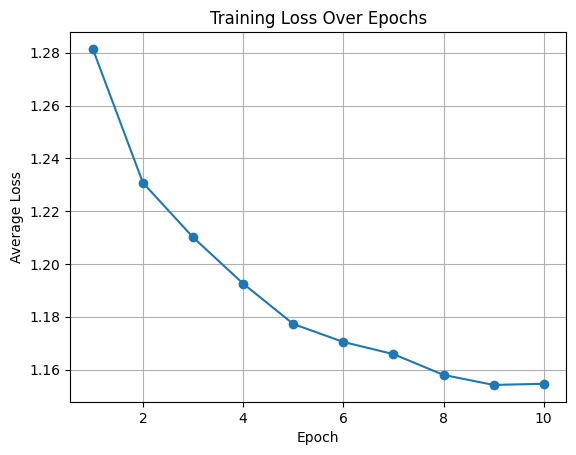

No bounding box errors encountered!


In [ ]:
train_model(
    model=model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    drive_checkpoint_dir=checkpoint_dir,
    val_loader=None
)